<a href="https://colab.research.google.com/github/kennedynjoroge/Algorithmic-Forex-Trading/blob/master/Forex_Algorithmic_Trading_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forex Algorithmic Trading Prediction


## 1.0 Defining the question
### Objective
Predict the highest and lowest price of the candle in the next upcoming hour.

### Metric for success
- Accuracy of predicted highest and lowest price.
- Cummulative net profit of the orders based on predicted signals.
- Number of won/lost orders

### Understanding the context
Foreign Exchange(FOREX) is the global market that allows the exchange of one currency for another. 5.3 trillion dollars worth of forex are traded daily. The forex market is open 24 hours a day and 5 days a week, only closing down during the weekend. The day starts when traders wake up in Sydney then moves to Tokyo, London, Frankfurt and finally, New York, before trading starts all over again in Sydney!

Buying a currency is buying a share in a particular country. The price of the currency is usually a direct reflection of the market’s opinion on the current and future health of its respective economy.

Forex trading is the simultaneous buying of one currency and selling another. Currencies are traded through a broker or dealer, and are traded in pairs e.g USD/JPY(US dollars/Japanese Yen).

The forex market is a decentralized global network of trading partners, including banks, public and private institutions, retail dealers, speculators, and central banks in-volved in the business of buying and selling money. Trades can take place anywhere as long as you have an Internet connection! While forex market has commercial and financial transactions as part of the trading volume, 90% currency trading is based on speculation. 

You would buy the pair if you believe the base currency will appreciate (gain value) relative to the quote currency.
You would sell the pair if you think the base currency will depreciate (lose value) relative to the quote currency.

90% of retail buyers lose money due to making of wrong decision. Therebeing, objective is to use machine learning to increase the chances of making a profit.
More info about forex trading available here -> https://www.babypips.com/learn/forex/

### Data Source
- Forex Capital Markets(FXCM), is a retail broker. Python wrapper API utilized to extract historical bid(sell) and ask(buy) data for USD/JPY instrument.
Historical data is useful for detailed examination of a market's past behaviour, traders and investors can gain perspective on the inner workings of that market.

- Quandl a marketplace for financial, economic data. Python wrapper API utilized to extract fundamental datasets i.e interest and employment rates.


### Assumptions
- Data from demo/sandbox is similar to production.
- Currency and Fundamental data e.g interest rates is valid.

## 2.0 Libraries and Data Importation



### Import Libraries


In [0]:
import datetime  as dt # Import data as date time
import pytz #Convert UTC to GMT+3
import numpy as np
import pandas as pd
import plotly.graph_objects as go 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import os
import time

#Imputation
from sklearn.impute import KNNImputer

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#LSTM modelling libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm_notebook
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import mean_squared_error


Mount Google Drive to facilitate reading the fxcm config file

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## FXCM API - for importing currencies
# API definition https://www.fxcm.com/fxcmpy/appendix.html
!pip  install fxcmpy -q 
!pip install python-socketio -q 
import fxcmpy
# api token/key. Check if connection exists else reconnect
try:
    api.get_instruments()
except:
    api = fxcmpy.fxcmpy(config_file='gdrive/My Drive/Colab Notebooks/Forex/fxcm.cfg')
    #api = fxcmpy.fxcmpy(config_file='gdrive/My Drive/Colab Notebooks/Forex/fxcm.cfg)

     |████████████████████████████████| 204kB 8.3MB/s 
     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 


In [0]:
## Quandl API - for fundamanetal data import e.g interest rate, employment rate.
# API Definition https://www.quandl.com/data/FRED-Federal-Reserve-Economic-Data/documentation
!pip install quandl -q 
import quandl
# api token/key
quandl.ApiConfig.api_key = "Y4Z_EXQ7qh7xxJhC8J6E"

In [0]:
# Ensure all columns are displayed
pd.pandas.set_option('display.max_rows', None)

### Import Bid and Ask Historical Data

Import historical bid and ask currency prices data. Will import 10 data for 10 years for starters. If need be, the years will be increased to enhance model accuracy by providing more data to make it able to generalize better.

Dataset is hourly candle data. Candlesticks describe the price action during the given time frame.

In [0]:
data_201920 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2019, 3, 30), stop = dt.datetime(2020, 3, 30))
data_201819 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2018, 3, 30), stop = dt.datetime(2019, 3, 30))
data_201718 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2017, 3, 30), stop = dt.datetime(2018, 3, 30))
data_201617 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2016, 3, 30), stop = dt.datetime(2017, 3, 30))
data_201516 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2015, 3, 30), stop = dt.datetime(2016, 3, 30))
data_201415 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2014, 3, 30), stop = dt.datetime(2015, 3, 30))
data_201314 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2013, 3, 30), stop = dt.datetime(2014, 3, 30))
data_201213 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2012, 3, 30), stop = dt.datetime(2013, 3, 30))
data_201112 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2011, 3, 30), stop = dt.datetime(2012, 3, 30))
data_201011 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2010, 3, 30), stop = dt.datetime(2011, 3, 30))

#Concatenate data for all the 10 years
years_list = [data_201920, data_201819, data_201718, data_201617, data_201516, data_201415, data_201314, data_201213, data_201112, data_201011]
df = pd.concat(years_list)

#Print Count
print("Count of hourly records per year \n")
print("2019-2020 - ",len(data_201920))
print("2018-2019 - ",len(data_201819))
print("2017-2018 - ",len(data_201718))
print("2016-2017 - ",len(data_201617))
print("2015-2016 - ",len(data_201516))
print("2014-2015 - ",len(data_201415))
print("2013-2014 - ",len(data_201314))
print("2012-2013 - ",len(data_201213))
print("2011-2012 - ",len(data_201112))
print("2010-2011 - ",len(data_201011))
print("\n Merged Data",len(df))

#View Sample
print("\n Sample Records From the DataFrame Before and After Time Conversion")
print(df.head(5)) # Before time convertsion
df = df.tz_localize("UTC").tz_convert('Africa/Nairobi').tz_localize(None)
df.head(5)

Count of hourly records per year 

2019-2020 -  6300
2018-2019 -  6308
2017-2018 -  6330
2016-2017 -  6331
2015-2016 -  6363
2014-2015 -  6309
2013-2014 -  6296
2012-2013 -  6217
2011-2012 -  6281
2010-2011 -  6247

 Merged Data 62982

 Sample Records From the DataFrame Before and After Time Conversion
                     bidopen  bidclose  bidhigh  ...  askhigh   asklow  tickqty
date                                             ...                           
2019-03-31 18:00:00  110.847   110.954  110.993  ...  110.998  110.970      193
2019-03-31 19:00:00  110.954   111.007  111.018  ...  111.030  110.974      215
2019-03-31 20:00:00  111.007   111.013  111.091  ...  111.107  111.012      321
2019-03-31 21:00:00  111.013   110.932  111.041  ...  111.086  110.893     1320
2019-03-31 22:00:00  110.932   110.936  110.983  ...  110.999  110.911     7250

[5 rows x 9 columns]


bidopen  bidclose  bidhigh  ...  askhigh   asklow  tickqty
date                                             ...                           
2019-03-31 21:00:00  110.847   110.954  110.993  ...  110.998  110.970      193
2019-03-31 22:00:00  110.954   111.007  111.018  ...  111.030  110.974      215
2019-03-31 23:00:00  111.007   111.013  111.091  ...  111.107  111.012      321
2019-04-01 00:00:00  111.013   110.932  111.041  ...  111.086  110.893     1320
2019-04-01 01:00:00  110.932   110.936  110.983  ...  110.999  110.911     7250

[5 rows x 9 columns]

Each row represents a candle of data for a single hour per day for USD/JPY currency pair.

a) Date - Date and hour. Date is originally in UTC/GMT. It's converted to GMT+3 local time

b) BID PRICES - Price that retailer trader sells at

- Bid open - price at the start of the candle

- Bid close - price at the end of the candle

- Bid high - highest price during the candle window

- Bid low - lowest price during the candle window

c) ASK PRICES - Price that retailer trader buys at

- Ask open - price at the start of the candle

- Ask close - price at the end of the candle

- Ask high - highest price during the candle window

- Ask low - lowest price during the candle window

d) Ticket Qty -  number of price changes that occured within the candle boundaries. It does not tell when the changes occured or how big or small the changes were.

In [0]:
df.describe()

bidopen      bidclose  ...        asklow        tickqty
count  62982.000000  62982.000000  ...  62982.000000   62982.000000
mean     101.712099    101.712334  ...    101.647944    7699.385952
std       13.967401     13.967371  ...     13.959858    8652.320233
min       75.671000     75.671000  ...     75.575000       1.000000
25%       88.504250     88.504250  ...     88.413500    2204.000000
50%      106.289500    106.290000  ...    106.225000    5221.000000
75%      111.729000    111.729000  ...    111.677000   10287.000000
max      125.676000    125.676000  ...    125.617000  171038.000000

[8 rows x 9 columns]

## Fundamental Features

### Interest Rates

Read US and Japanese Interest rates for the last 10 years from quandl API

In [0]:
# Read US Interest rates from quandl for the last 10 years
# API frequency is daily
v_start_date = '2010-03-30'
v_end_date = '2020-03-30'
df_US_Interest_Rates = quandl.get("FRED/DFF", start_date=v_start_date, end_date=v_end_date,timezone='GMT+3')
df_US_Interest_Rates.columns = df_US_Interest_Rates.columns.str.replace('Value', 'US_Daily_Interest_Rate')
df_JPY_Interest_Rates = quandl.get("MOFJ/INTEREST_RATE_JAPAN_40Y", start_date=v_start_date, end_date=v_end_date,timezone='GMT+3')
df_JPY_Interest_Rates.columns = df_JPY_Interest_Rates.columns.str.replace('Value', 'JPY_Daily_Interest_Rate')

#Create transaction date from index
df['Transaction_Date'] = df.index.strftime('%Y-%m-%d')
df['Candle_Date'] = df.index
df_US_Interest_Rates['Transaction_Date']  = df_US_Interest_Rates.index.strftime('%Y-%m-%d')
df_JPY_Interest_Rates['Transaction_Date']  = df_JPY_Interest_Rates.index.strftime('%Y-%m-%d')

df_JPY_Interest_Rates[0:5]

JPY_Daily_Interest_Rate Transaction_Date
Date                                                
2010-03-30                    2.320       2010-03-30
2010-03-31                    2.308       2010-03-31
2010-04-01                    2.285       2010-04-01
2010-04-02                    2.258       2010-04-02
2010-04-05                    2.259       2010-04-05

In [0]:
# Check length of Japanese versus US interest rates
print(len(df_JPY_Interest_Rates), len(df_US_Interest_Rates))

2448 3654


Some Japanese interest rates missing compared to US interest rates. Imputation to be preferred based on nearest neigbour

### Merge Currency and Interest Data

In [0]:
# Merge Dataframe and  US interest rates
df = df.merge(df_US_Interest_Rates,on='Transaction_Date',how='left')
df.set_index("Candle_Date", inplace = True) 
df[0:3]

bidopen  bidclose  ...  Transaction_Date  US_Daily_Interest_Rate
Candle_Date                             ...                                          
2019-03-31 21:00:00  110.847   110.954  ...        2019-03-31                    2.43
2019-03-31 22:00:00  110.954   111.007  ...        2019-03-31                    2.43
2019-03-31 23:00:00  111.007   111.013  ...        2019-03-31                    2.43

[3 rows x 11 columns]

In [0]:
# Merge Dataframe and  Japan interest rates
df['Candle_Date'] = df.index
df = df.merge(df_JPY_Interest_Rates,on='Transaction_Date',how='left')
df.set_index("Candle_Date", inplace = True) 
df[0:20]

bidopen  ...  JPY_Daily_Interest_Rate
Candle_Date                   ...                         
2019-03-31 21:00:00  110.847  ...                      NaN
2019-03-31 22:00:00  110.954  ...                      NaN
2019-03-31 23:00:00  111.007  ...                      NaN
2019-04-01 00:00:00  111.013  ...                    0.601
2019-04-01 01:00:00  110.932  ...                    0.601
2019-04-01 02:00:00  110.936  ...                    0.601
2019-04-01 03:00:00  110.982  ...                    0.601
2019-04-01 04:00:00  111.075  ...                    0.601
2019-04-01 05:00:00  111.145  ...                    0.601
2019-04-01 06:00:00  111.118  ...                    0.601
2019-04-01 07:00:00  111.076  ...                    0.601
2019-04-01 08:00:00  111.010  ...                    0.601
2019-04-01 09:00:00  111.038  ...                    0.601
2019-04-01 10:00:00  111.061  ...                    0.601
2019-04-01 11:00:00  111.040  ...                    0.601
2019-04-01 12:00:00  111.005  ...                    0.601
2019-04-01 13:00:00  110.991  ...                    0.601
2019-04-01 14:00:00  110.948  ...                    0.601
2019-04-01 15:00:00  110.981  ...                    0.601
2019-04-01 16:00:00  110.932  ...                    0.601

[20 rows x 12 columns]

Impute missing Japanese Currency data

In [0]:
#Impute JPY Interest Rates Using KNN Imputer
JPY_Interest_rate = df['JPY_Daily_Interest_Rate'].values
JPY_Interest_rate = JPY_Interest_rate.reshape(-1, 1)
imputer = KNNImputer(n_neighbors=2)
df['JPY_Daily_Interest_Rate'] = imputer.fit_transform(JPY_Interest_rate)

In [0]:
df[0:10]

bidopen  ...  JPY_Daily_Interest_Rate
Candle_Date                   ...                         
2019-03-31 21:00:00  110.847  ...                 1.414148
2019-03-31 22:00:00  110.954  ...                 1.414148
2019-03-31 23:00:00  111.007  ...                 1.414148
2019-04-01 00:00:00  111.013  ...                 0.601000
2019-04-01 01:00:00  110.932  ...                 0.601000
2019-04-01 02:00:00  110.936  ...                 0.601000
2019-04-01 03:00:00  110.982  ...                 0.601000
2019-04-01 04:00:00  111.075  ...                 0.601000
2019-04-01 05:00:00  111.145  ...                 0.601000
2019-04-01 06:00:00  111.118  ...                 0.601000

[10 rows x 12 columns]

### Unemployment rates

In [0]:
#  % of Total Labor Force. API Frequency is annual. 
US_Unemployment_percent = quandl.get("ODA/JPN_LUR", start_date=v_start_date, end_date=v_end_date)
JPY_Unemployment_percent = quandl.get("ODA/USA_LUR", start_date=v_start_date, end_date=v_end_date)
# quandl.get("ODA/USA_LUR", authtoken="Y4Z_EXQ7qh7xxJhC8J6E")
print("Japanese Unemployment rate: ",len(JPY_Unemployment_percent), " US_Unemployment_percent: ",len(US_Unemployment_percent))
US_Unemployment_percent

Japanese Unemployment rate:  10  US_Unemployment_percent:  10


Value
Date             
2010-12-31  5.058
2011-12-31  4.583
2012-12-31  4.325
2013-12-31  4.008
2014-12-31  3.583
2015-12-31  3.375
2016-12-31  3.108
2017-12-31  2.817
2018-12-31  2.442
2019-12-31  2.433

## Feature Engineering

In [0]:
## Extract date time features.
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

##Spread
#A spread is the price difference between where a trader may purchase or sell an underlying asset. 
df['spread']= df['askclose'] - df['bidclose']

### Bid High
## Bid High Return
# References: https://quant.stackexchange.com/questions/21092/calculating-log-returns-across-multiple-securities-and-time , https://stackoverflow.com/questions/31742545/python-calculating-log-returns-of-a-time-series
# NB: In Quantitative Finance, doing your math in log-returns considered good manners
df['bid_high_return'] = np.log(df['bidhigh']/df['bidhigh'].shift(1))

## Bid Close Up or Down
#Was the bid close price up or down
df['bid_high_up_down'] = np.where(df['bid_high_return'] >0 ,1,0) # Bid Close went up or down?

#Simple Moving Average
df['bid_high_rolling_mean_20'] = df['bidhigh'].rolling(window=20).mean()
df['bid_high_rolling_mean_50'] = df['bidhigh'].rolling(window=50).mean()
df['bid_high_rolling_mean_120'] = df['bidhigh'].rolling(window=120).mean()

#Bid Average, Range, ohlc_price, diff
df['bid_avg'] = (df['bidlow'] + df['bidhigh']) / 2
df['bid_range'] = df['bidhigh'] - df['bidlow']
df['bid_ohlc_price'] = (df['bidlow'] + df['bidhigh'] + df['bidopen'] + df['bidclose']) / 4
df['bid_diff'] = df['bidopen'] - df['bidclose']

#Bid high label
df['bid_high_next'] = df['bidhigh'].shift(-1)

### Ask Low
## Ask Low Return
# References: https://quant.stackexchange.com/questions/21092/calculating-log-returns-across-multiple-securities-and-time , https://stackoverflow.com/questions/31742545/python-calculating-log-returns-of-a-time-series
# NB: In Quantitative Finance, doing your math in log-returns considered good manners
df['ask_low_return'] = np.log(df['asklow']/df['asklow'].shift(1))

## Bid Close Up or Down
#Was the bid close price up or down
df['ask_low_up_down'] = np.where(df['ask_low_return'] >0 ,1,0) # Bid Close went up or down?

#Simple Moving Average
df['ask_low_rolling_mean_20'] = df['asklow'].rolling(window=20).mean()
df['ask_low_rolling_mean_50'] = df['asklow'].rolling(window=50).mean()
df['ask_low_rolling_mean_120'] = df['asklow'].rolling(window=120).mean()


#Ask Average, Range
df['ask_avg'] = (df['askhigh'] + df['asklow']) / 2
df['ask_range'] = df['askhigh'] - df['asklow']
df['ask_ohlc_price'] = (df['asklow'] + df['askhigh'] + df['askopen'] + df['askclose']) / 4
df['ask_diff'] = df['askopen'] - df['askclose']

#ASk low label
df['asklow_next'] = df['asklow'].shift(-1)


# Difference of order one.
# Y - Y-1
# df['bid_order1_difference'] = df['bid_high_next'] - df['bidhigh']

# will it be same formula with respect to ask_momentum? was the question i was asking myself..to revisit l8r
# df['bid_momentum'] = df['tickqty'] * (df['bidopen'] - df['bidclose'])


bidhigh versus bidhigh_next  Labels

In [0]:
df[['bidhigh','bid_high_next']][0:5]

bidhigh  bid_high_next
Candle_Date                                
2019-03-31 21:00:00  110.993        111.018
2019-03-31 22:00:00  111.018        111.091
2019-03-31 23:00:00  111.091        111.041
2019-04-01 00:00:00  111.041        110.983
2019-04-01 01:00:00  110.983        110.995

## Exploratory Data Analysis

### Data Cleaning

a) Missing records

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62982 entries, 2019-03-31 21:00:00 to 2011-03-30 03:00:00
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bidopen                    62982 non-null  float64
 1   bidclose                   62982 non-null  float64
 2   bidhigh                    62982 non-null  float64
 3   bidlow                     62982 non-null  float64
 4   askopen                    62982 non-null  float64
 5   askclose                   62982 non-null  float64
 6   askhigh                    62982 non-null  float64
 7   asklow                     62982 non-null  float64
 8   tickqty                    62982 non-null  int64  
 9   Transaction_Date           62982 non-null  object 
 10  US_Daily_Interest_Rate     62982 non-null  float64
 11  JPY_Daily_Interest_Rate    62982 non-null  float64
 12  year                       62982 non-null  int64  
 13  quarter    

In [0]:
df = df.dropna()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62862 entries, 2019-04-05 20:00:00 to 2011-03-30 02:00:00
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bidopen                    62862 non-null  float64
 1   bidclose                   62862 non-null  float64
 2   bidhigh                    62862 non-null  float64
 3   bidlow                     62862 non-null  float64
 4   askopen                    62862 non-null  float64
 5   askclose                   62862 non-null  float64
 6   askhigh                    62862 non-null  float64
 7   asklow                     62862 non-null  float64
 8   tickqty                    62862 non-null  int64  
 9   Transaction_Date           62862 non-null  object 
 10  US_Daily_Interest_Rate     62862 non-null  float64
 11  JPY_Daily_Interest_Rate    62862 non-null  float64
 12  year                       62862 non-null  int64  
 13  quarter    

b) Duplicate records

In [0]:
pass

c) Outliers

In [0]:
pass

###  Univariate Analysis

#### a) Candlesticks for the last 10 years

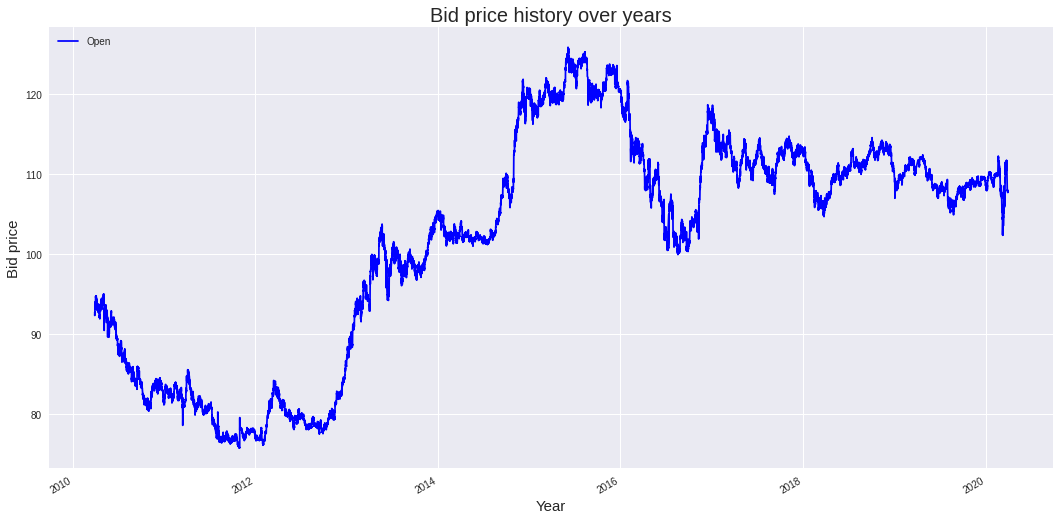

In [0]:
plt.figure(figsize = (18,9))
#plt.plot(df.index,df['bidhigh'],color='b',label='True')
#df['bidopen'].plot(color='red',label='True')
df['bidhigh'].plot(color='blue',label='True')
#df['bidlow'].plot(color='b',label='True')
#df['bidclose'].plot(color='',label='True')
#df['bid_high_rolling_mean_3'].plot(color='red',label='True')
# plt.plot(df['bidopen'])
# plt.plot(df['bidhigh'])
# plt.plot(df['bidlow'])
# plt.plot(df["bidclose"])
plt.title('Bid price history over years', fontsize =20)
plt.ylabel('Bid price', fontsize =15)
plt.xlabel('Year', fontsize =15)
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

#### b) Moving Average

A moving average is commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles

In [0]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    # plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    rolling_mean.plot(label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        upper_bound.plot(label='Upper bound / Lower bound' )
        # plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound', )
        # plt.plot(lower_bound, 'r--')
        lower_bound.plot()
            
    # plt.plot(series[window:], label='Actual values')
    series[window:].plot(label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

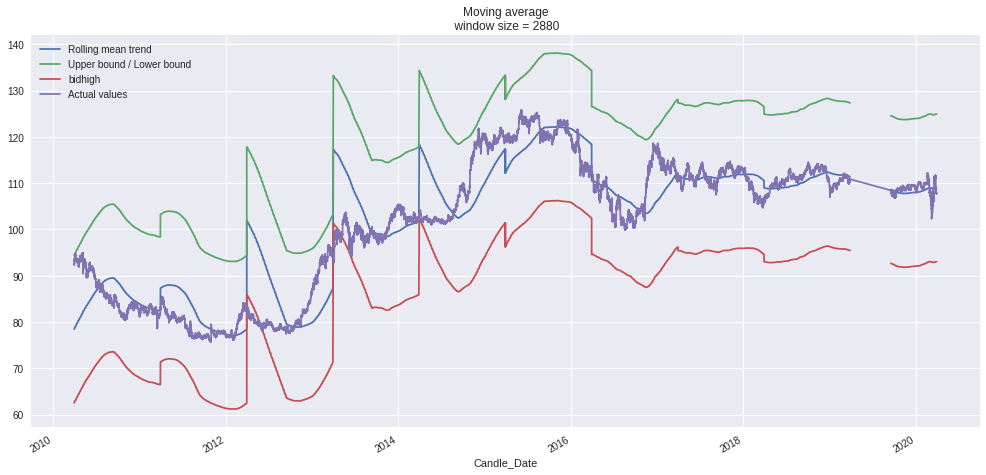

In [0]:
#Smooth by the previous 120 previous days i.e 120*24
plot_moving_average(df['bidhigh'], 2880, plot_intervals=True)

#### Exponential smoothing

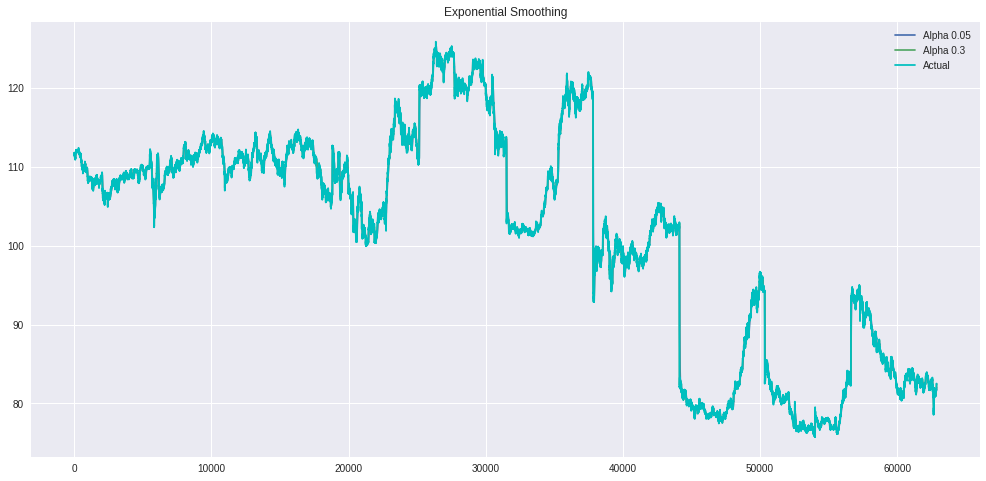

In [0]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(df.bidhigh, [0.05, 0.3])

In [0]:
#Create Plot
fig = go.Figure(data=[go.Candlestick(x=df.index,open=df['bidopen'],high=df['bidhigh'],low=df['bidlow'],close=df['bidclose'])])
#Specify title and y axis
fig.update_layout( title='Forex Pricing Patterns for last 10 years',yaxis_title='Price',xaxis_title='Year')
fig.show(renderer = "colab",auto_open=True)
# fig.write_html('tmp.html', auto_open=True)

Price was lowest in 2012 and highest in 2016


b) High, Low Prices Line Plot

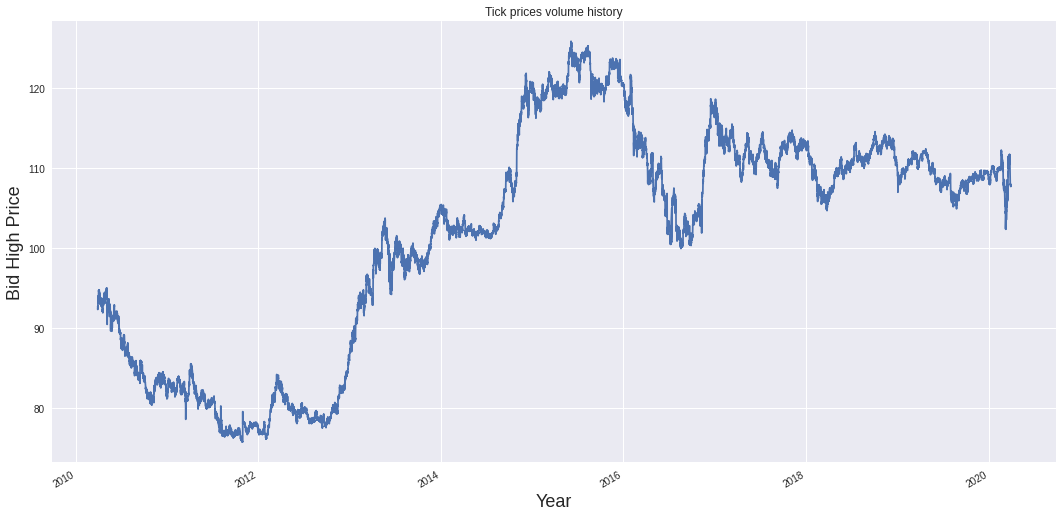

In [0]:
plt.figure(figsize = (18,9))
df['bidhigh'].plot()
plt.title('Tick prices volume history')
plt.xlabel('Year',fontsize=18)
plt.ylabel('Bid High Price',fontsize=18)
plt.show()

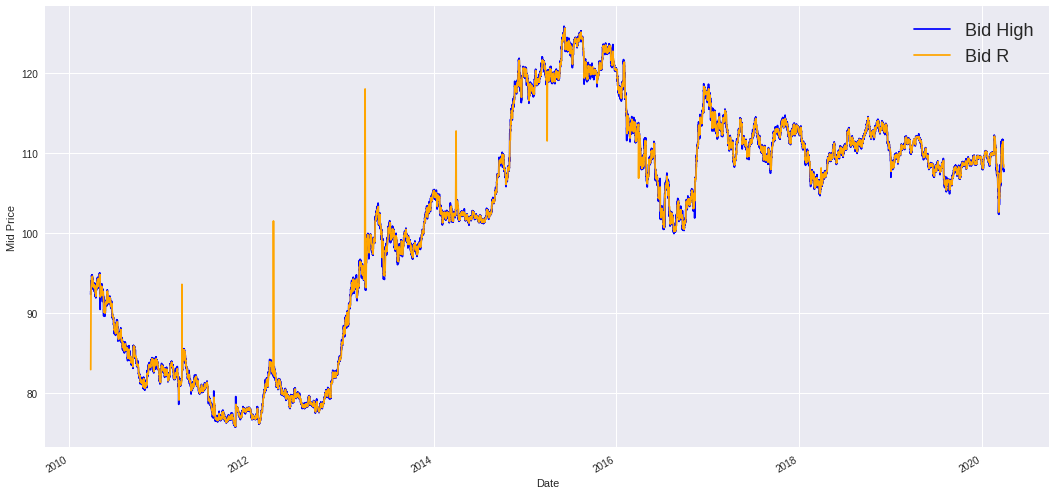

In [0]:
plt.figure(figsize = (18,9))
df['bidhigh'].plot(color='b',label='Bid High')
df['bid_high_rolling_mean_20'].plot(color='orange',label='Bid R')
#plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
#plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

c) Order 1 Difference i.e y -(y-1)

In [0]:
pass

Tick Prices Volume History

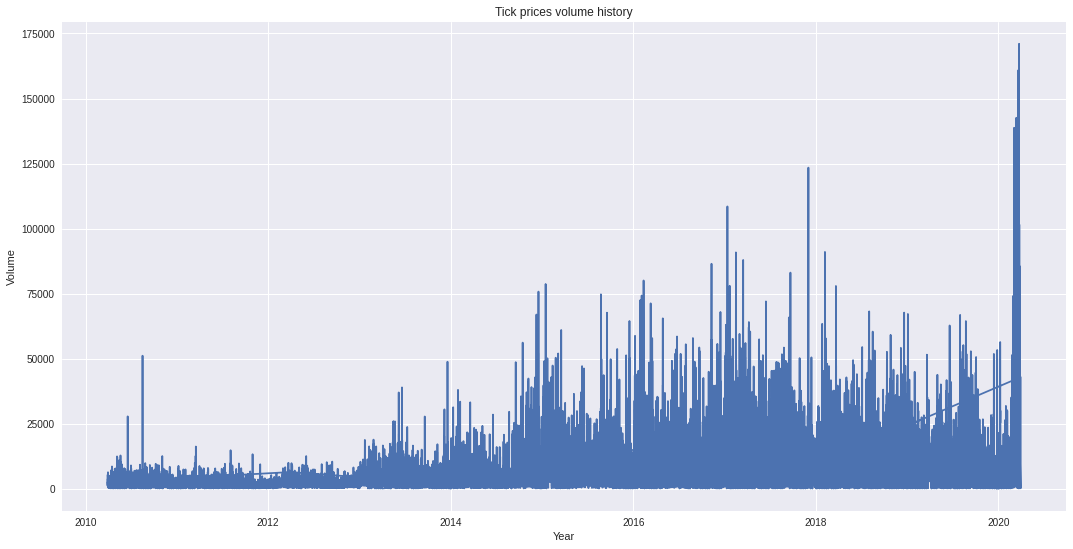

In [0]:
plt.figure(figsize = (18,9))
plt.plot(df["tickqty"])
#plt.plot(df.index,df['bidhigh'],color='red',label='True')
#plt.plot(df.index,df['bid_high_rolling_mean_2'],color='orange',label='True')
#plt.plot(df['bidhigh'],color='red',label='True')
plt.title('Tick prices volume history')
plt.ylabel('Volume')
plt.xlabel('Year')
plt.show()

## Bivariate Analysis

Correlation

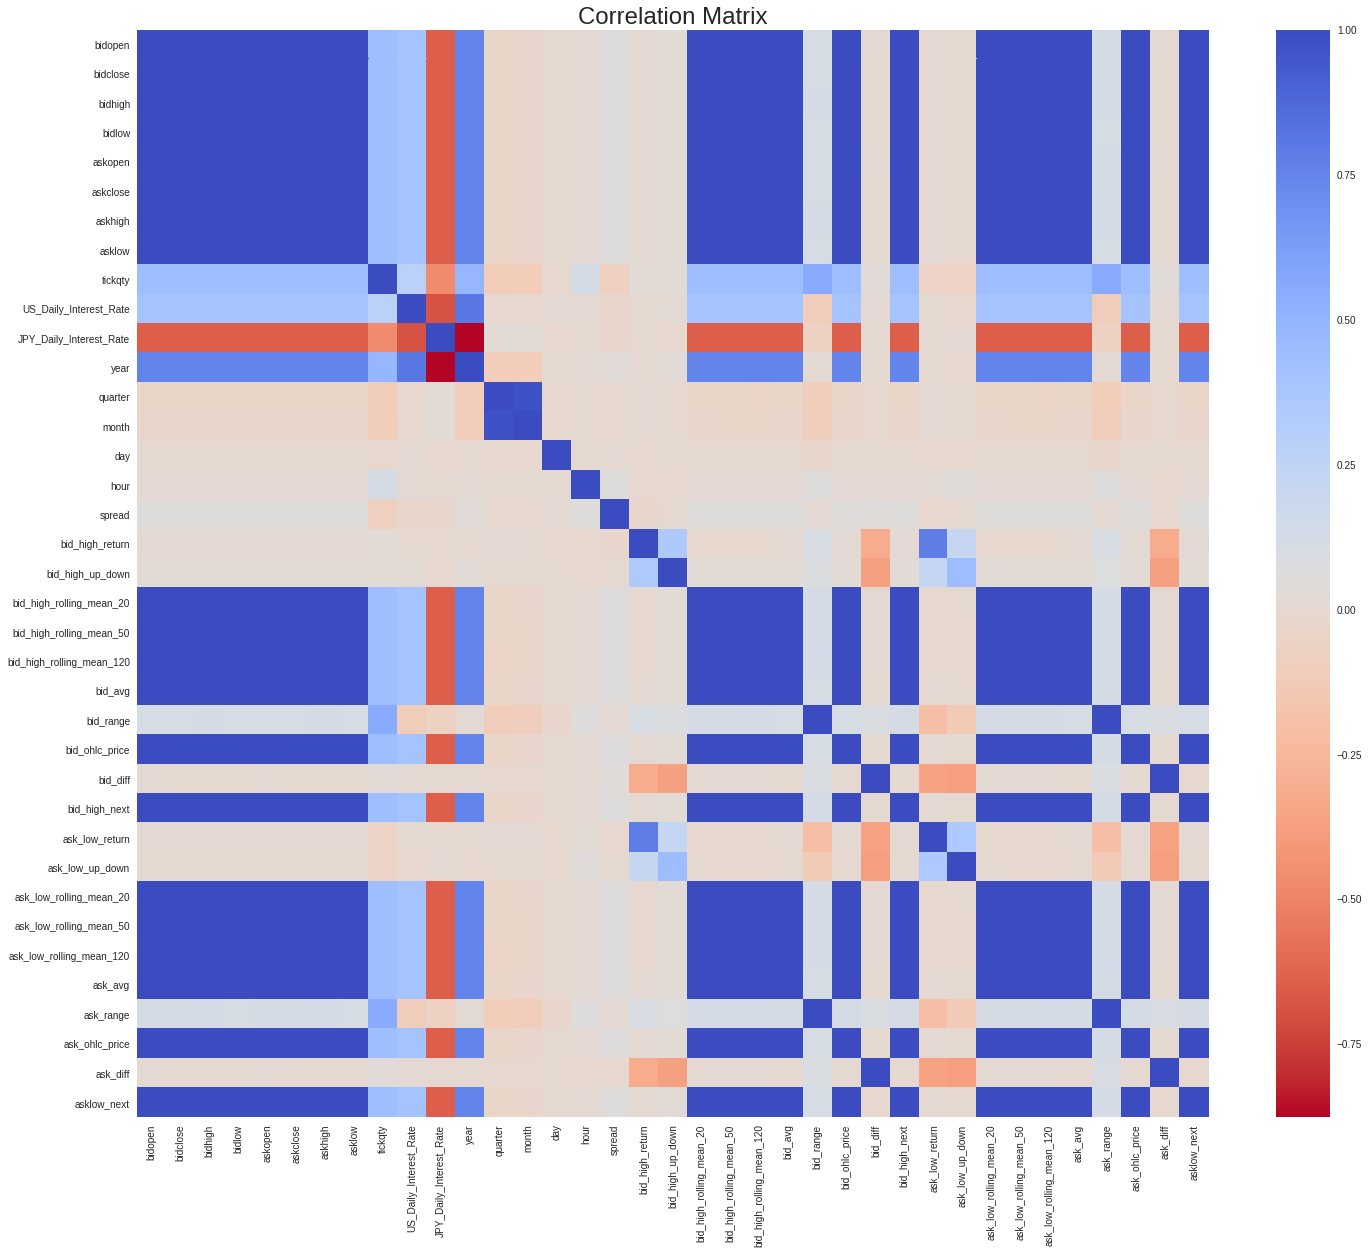

In [0]:
# Calculate pearson correlation coefficience
corr = df.corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
ax.set_title("Correlation Matrix", fontsize=24)
plt.show()

## Multivariate Analysis

## Pre-Modelling Steps

a) Drop unrequired columns

In [0]:
# Drop  non-required columns
df = df.drop(['Transaction_Date'], axis=1)

## Modelling

The model should be able to:
- Identify trends as early as possible.
- Avoid one from getting whipsawed 

### a) Support Machine Vector
- Check with Radial as well versus linear and compare results


In [0]:
# columns = ['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose',
#        'askhigh', 'asklow', 'tickqty', 'US_Daily_Interest_Rate', 'JPY_Daily_Interest_Rate', 'year', 'quarter',
#        'month', 'day', 'hour', 'spread', 'bid_close_return',
#        'bid_close_up_down', 'bid_close_rolling_mean_1',
#        'bid_close_rolling_mean_2', 
#        'bid_high_rolling_mean_1', 'bid_high_rolling_mean_2', 'bid_high_next']
# labels = df['bid_high_up_down'].values #bid_high_next 'bid_close_return',  'bid_high_up_down'
# features = df[list(columns)].values

# min_max = MinMaxScaler()
# newfeatures = min_max.fit_transform(features)
# X_train, X_test, y_train, y_test = train_test_split(newfeatures, labels, test_size=0.1)

In [0]:
# clf = svm.SVC(kernel='linear')
# clf = clf.fit(X_train, y_train)

# accuracy = clf.score(X_train, y_train)
# print (' training data accuracy ', accuracy*100)

# accuracy = clf.score(X_test, y_test)
# print (' testing data accuracy ', accuracy*100)

# ypredict = clf.predict(X_train)
# print ('\n Training classification report\n', classification_report(y_train, ypredict))

# ypredict = clf.predict(X_test)
# print ('\n Testing classification report\n', classification_report(y_test, ypredict))

### c) LSTM

LSTMs selected as it's frequently used to model time series forecasting problems.

Specify dependent and independent variables, scale and split

### Split and Scale the Features

In [0]:
df.columns

Index(['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose',
       'askhigh', 'asklow', 'tickqty', 'US_Daily_Interest_Rate',
       'JPY_Daily_Interest_Rate', 'year', 'quarter', 'month', 'day', 'hour',
       'spread', 'bid_high_return', 'bid_high_up_down',
       'bid_high_rolling_mean_20', 'bid_high_rolling_mean_50',
       'bid_high_rolling_mean_120', 'bid_avg', 'bid_range', 'bid_ohlc_price',
       'bid_diff', 'bid_high_next', 'ask_low_return', 'ask_low_up_down',
       'ask_low_rolling_mean_20', 'ask_low_rolling_mean_50',
       'ask_low_rolling_mean_120', 'ask_avg', 'ask_range', 'ask_ohlc_price',
       'ask_diff', 'asklow_next'],
      dtype='object')

In [0]:
df[0:5]

bidopen  bidclose  ...  ask_diff  asklow_next
Candle_Date                             ...                       
2019-04-05 20:00:00  111.727   111.701  ...     0.025      111.687
2019-04-05 21:00:00  111.701   111.686  ...     0.016      111.674
2019-04-05 22:00:00  111.686   111.670  ...     0.015      111.682
2019-04-05 23:00:00  111.670   111.694  ...    -0.073      111.722
2019-04-07 22:00:00  111.694   111.657  ...     0.035      111.680

[5 rows x 37 columns]

In [0]:
#Check column index for ask low next and bigh hid next
df.iloc[:,36][0:5]
forex_data.iloc[:,][0:5]
#Bid high next - 26
#Ask hih next - 36

NameError: ignored

#### a) Split the train and test

In [0]:
def  split_train_test(bid_or_ask,train_percentage,test_percentage):
  '''
  Split train or test depending on whether it's ask or bid
  '''
              # removed asklow_next
  bid_cols = ['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose','askhigh', 'asklow', 'tickqty','bid_high_next','US_Daily_Interest_Rate','JPY_Daily_Interest_Rate',
       'year', 'quarter', 'month', 'day', 'hour',
       'spread', 'bid_high_return', 'bid_high_up_down',
       'bid_high_rolling_mean_20', 'bid_high_rolling_mean_50',
       'bid_high_rolling_mean_120',]
  # bid_cols = ['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose',
  #      'askhigh', 'asklow', 'tickqty', 'US_Daily_Interest_Rate',
  #      'JPY_Daily_Interest_Rate', 'year', 'quarter', 'month', 'day', 'hour',
  #      'spread', 'bid_high_return', 'bid_high_up_down',
  #      'bid_high_rolling_mean_20', 'bid_high_rolling_mean_50',
  #      'bid_high_rolling_mean_120', 'bid_avg', 'bid_range', 'bid_ohlc_price',
  #      'bid_diff', 'bid_high_next', 'ask_low_return', 'ask_low_up_down',
  #      'ask_low_rolling_mean_20', 'ask_low_rolling_mean_50',
  #      'ask_low_rolling_mean_120', 'ask_avg', 'ask_range', 'ask_ohlc_price',
  #      'ask_diff'] 
            # Removed bidhigh_next
  ask_cols = ['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose',
       'askhigh', 'asklow', 'tickqty', 'US_Daily_Interest_Rate',
       'JPY_Daily_Interest_Rate', 'year', 'quarter', 'month', 'day', 'hour',
       'spread', 'bid_high_return', 'bid_high_up_down',
       'bid_high_rolling_mean_20', 'bid_high_rolling_mean_50',
       'bid_high_rolling_mean_120', 'bid_avg', 'bid_range', 'bid_ohlc_price',
       'bid_diff', 'ask_low_return', 'ask_low_up_down',
       'ask_low_rolling_mean_20', 'ask_low_rolling_mean_50',
       'ask_low_rolling_mean_120', 'ask_avg', 'ask_range', 'ask_ohlc_price',
       'ask_diff', 'asklow_next']

  if bid_or_ask == 'bid':
      cols = bid_cols
  else:
      cols = ask_cols

  #Split using 80 20 ratio.
#  df_train, df_test = train_test_split(df, train_size=0.6, test_size=0.4, shuffle=False)
  df_train, df_test = train_test_split(df, train_size=train_percentage, test_size=test_percentage, shuffle=False)
  print("Train and Test size", len(df_train), len(df_test))

  # Scale the feature MinMax, build array

  x = df_train.loc[:,cols].values
  min_max_scaler = MinMaxScaler()
  x_train = min_max_scaler.fit_transform(x)
  x_test = min_max_scaler.transform(df_test.loc[:,cols])

  return (x_train,x_test,min_max_scaler)

#### b) Convert train test data to time series. 

Splits data into multiple samples where each sample has a specified number of time steps and the output is a dependent and independent variable time steps input output.

Splits the train and test data into 3 dimenstional array. 

-> Batch Size - how many samples of input will Neural Net see before updating the weights.

-> Time Steps define how many units back in time you want the network to see.

-> Features is the number of attributes used to represent each time step.


In [0]:
def build_timeseries(forex_data, y_col_index, time_steps):
    """
    y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(forex_data) - time steps
    """
    dim_0 = forex_data.shape[0] - time_steps
    dim_1 = forex_data.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = forex_data[i:time_steps+i]
        y[i] = forex_data[time_steps+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(forex_data, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = forex_data.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        print("Number of rows to drop:", no_of_rows_drop)
        return forex_data[:-no_of_rows_drop]
    else:
        return forex_data

In [0]:
def convert_train_test_timeseries(bid_or_ask):

  if bid_or_ask == 'bid':
      label_column_idx = BID_HIGH_NEXT_COLUMN_IDX
  else:
      label_column_idx = ASKLOW_NEXT_COLUMN_IDX

  x_train_time_series, y_train_time_series = build_timeseries(x_train, label_column_idx, TIME_STEPS
  
  )
  x_train_time_series = trim_dataset(x_train_time_series, BATCH_SIZE)

  y_train_time_series = trim_dataset(y_train_time_series, BATCH_SIZE)

  ## Test data set timeseries split
  x_test_time_series, y_test_time_series = build_timeseries(x_test, 3, TIME_STEPS)
  #Split the data into test and validation by half
  x_val, x_test_t = np.split(trim_dataset(x_test_time_series, BATCH_SIZE),2)
  y_val, y_test_t = np.split(trim_dataset(y_test_time_series, BATCH_SIZE),2)
  return x_train_time_series,y_train_time_series, x_val, x_test_t,y_val, y_test_t

#### c) Define an LSTM sequential model

In [0]:
# Define an LSTM sequential model
#ACTION: Consider adding more LSTM layers. Had added but was getting dimension error on second layer.
def create_model(batch_size,time_steps,lr,features):
  model = Sequential()
  model.add(LSTM(64, batch_input_shape=(batch_size, time_steps, features), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform')) #return_sequences=True,
  model.add(Dropout(0.4))
  #model.add(Dense(20,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  opt = RMSprop(lr=lr)
  model.compile(loss='mean_squared_error', optimizer=opt) #,metrics=['accuracy']
  return model



In [0]:
# def create_model(batch_size,time_steps,lr,features):
#   model = Sequential()
#   model.add(LSTM(100, return_sequences=True, batch_input_shape=(batch_size, time_steps, features), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform')) #return_sequences=True,
#   model.add(Dropout(0.4))
#   model.add(LSTM(32, return_sequences=True)) 
#   model.add(Dropout(0.4))
#   model.add(Dense(20,activation='relu'))
#   model.add(Dense(1,activation='sigmoid'))
#   opt = RMSprop(lr=lr)
#   model.compile(loss='mean_squared_error', optimizer=opt) #,metrics=['accuracy']
#   return model

In [0]:
# def create_model(batch_size,time_steps,lr,features):
#   model = Sequential()
#   model.add(LSTM(256, return_sequences=True, batch_input_shape=(batch_size, time_steps, features), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform')) #return_sequences=True,
#   model.add(Dropout(0.4))
#   model.add(LSTM(256, return_sequences=True)) 
#   model.add(Dropout(0.4))
#   model.add(Dense(20,activation='relu'))
#   model.add(Dense(1,activation='sigmoid'))
#   opt = RMSprop(lr=lr)
#   model.compile(loss='mean_squared_error', optimizer=opt) #,metrics=['accuracy']
#   return model

Fit the Model

In [0]:
def fit_model(model_name,x_train_time_series,y_train_time_series,x_val,y_val):
  #Log results to a file.
  csv_logger = CSVLogger('training log')
  # Early stopping :Monitor model performance on a validation set and stop training when performance degrades.
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
  # Save model best model as 'save_best_only=True'
  mcp = ModelCheckpoint(os.path.join(model_name), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
  history = model.fit(x_train_time_series, y_train_time_series, epochs=LSTM_MOD_EPOCHS, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp,csv_logger])
  return history

Plot Train and Validation Loss

In [0]:
def plot_model_train_history(history):
  # summarize history for loss
  plt.figure(figsize = (18,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Prediction

In [0]:
def prediction_from_test_date(x_test_t,y_test_t, scaler):
  y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
  y_pred = y_pred.flatten()

  y_test_t = trim_dataset(y_test_t, BATCH_SIZE)

  error = mean_squared_error(y_test_t, y_pred)
  print("Error is", error)
  

  # Convert the predicted value to range of real data
  y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3]
  y_test_t_org = (y_test_t * scaler.data_range_[3]) + scaler.data_min_[3]
  return (y_pred_org,y_test_t_org)

Plot Test Versus Predicted Outcome

In [0]:
def plot_pred_versus_test(y_pred,y_test):
  plt.figure(figsize = (18,9))
  plt.plot(y_pred)
  plt.plot(y_test)
  plt.title('Prediction vs Real Stock Price', fontsize=20)
  plt.ylabel('Bid Price', fontsize=16)
  plt.xlabel('Price Instances', fontsize=16)
  plt.legend(['Prediction', 'Real'], loc='upper right', fontsize=16)
  plt.show()

d) Execute the Model
*   Split Train and Test
*   Convert dependent and independent train test labels  into timeseries
*   Split test into validation and test
*   Define the model
*   Fit the model
*   Evaluate test results.







In [0]:
TIME_STEPS = 20
BATCH_SIZE = 20
LSTM_MOD_EPOCHS = 20
LEARNING_RATE = 0.0001
#BID_HIGH_NEXT_COLUMN_IDX =26
BID_HIGH_NEXT_COLUMN_IDX =9
ASKLOW_NEXT_COLUMN_IDX =35
test_percentage = 0.2
train_percentage = 0.8

#### Bid High Price Model

In [0]:
# Split
x_train,x_test,bid_scaler = split_train_test('bid',train_percentage,test_percentage)

In [0]:
# Convert to timeseries
x_bid_train_time_series,y_bid_train_time_series, x_bid_val, x_bid_test_t,y_bid_val, y_bid_test_t = convert_train_test_timeseries('bid') 
#Define model
model = create_model(BATCH_SIZE,TIME_STEPS,LEARNING_RATE,x_bid_train_time_series.shape[2])
# Display the model's architecture
model.summary()
# Fit Model
model_name = "bid_high_price_model.h5"
bid_history = fit_model(model_name,x_bid_train_time_series,y_bid_train_time_series,x_bid_val,y_bid_val)
plot_model_train_history(bid_history)

#### Ask Low Price Model

In [0]:
# Split
x_train,x_test,ask_scaler = split_train_test('ask',train_percentage,test_percentage)
# Convert to timeseries
x_ask_train_time_series,y_ask_train_time_series, x_ask_val, x_ask_test_t,y_ask_val, y_ask_test_t = convert_train_test_timeseries('ask') 
#Define model
model = create_model(BATCH_SIZE,TIME_STEPS,LEARNING_RATE,x_ask_train_time_series.shape[2])
# Display the model's architecture
model.summary()
# Fit Model
model_name = "ask_low_price_model.h5"
ask_history = fit_model(model_name,x_ask_train_time_series,y_ask_train_time_series,x_ask_val,y_ask_val)
plot_model_train_history(ask_history)

Validation loss decreasing with increase in epochs.

To eliminate overfitting:

- Increasing dropout rate

- Increased/Reducing the number of epochs

- Linear activation

- Reduced the timesteps from 600 to 30

# Get model Prediction

Bid Prediction

In [0]:
# Get Prediction
y_bid_pred ,y_bid_test= prediction_from_test_date(x_bid_test_t,y_bid_test_t, bid_scaler)

# Plot Prediction
plot_pred_versus_test(y_bid_pred,y_bid_test)

# Display actual figures
diff = y_bid_pred - y_bid_test
df_bid_pred = pd.DataFrame({"Pred" : y_bid_pred , "Actual" : y_bid_test,"Difference" : diff})
df_bid_pred[0:5]

Ask Prediction

In [0]:
# Get Prediction
y_ask_pred ,y_ask_test= prediction_from_test_date(x_ask_test_t,y_ask_test_t, ask_scaler)

# Plot Prediction
plot_pred_versus_test(y_ask_pred,y_ask_test)

# Display actual figures
diff = y_ask_pred - y_ask_test
df_ask_pred = pd.DataFrame({"Pred" : y_ask_pred , "Actual" : y_ask_test,"Difference" : diff})
df_ask_pred[0:5]

### Create Prediction from Streaming Data

Read Streaming Data

In [0]:
api.subscribe_market_data('USD/JPY')

In [0]:
api.get_prices('USD/JPY')

Create streaming data to independent variable format

Bid Prediction

Ask Prediction

### Make Orders

Open Positions

In [0]:
api.get_open_positions()

Create Buy Order

In [0]:
api.create_market_buy_order('USD/JPY', (10))
api.get_open_positions()

Create Sell Order

In [0]:
api.create_market_sell_order('USD/JPY', (100))
api.get_open_positions()

Buy Sell Engine

In [0]:
sel = ['tradeId', 'amountK', 'currency', 'grossPL', 'isBuy']
for _ in range(5):
    print(50 * '=')
    print('TRADE NO {}'.format(_))
    # GET DATA FOR LAST HOUR
    # GET PREDICTED ASK LOW AND BID HIGH PRICES
    
    ## GET STREAMING DATA
    ## If CURRENT ASK DATA IS NEAR PREDICTED LOW FOR THE HOUR
    ## BUY
    order = api.create_market_buy_order('USD/JPY', 100)
    time.sleep(1)
    ## VIEW POSITION
    print('POSITIONS\n', api.get_open_positions()[sel])
    time.sleep(7)

    ## IF CURRENT BID DATA IS NEAR THE PREDICTED POSITION, BUY
    api.close_all_for_symbol('USD/JPY')

    print('POSITIONS\n', api.get_open_positions())
    time.sleep(7)

### Conclusion

- Mean square errors (MSE) are very close to each other between training and validation datasets.

- Outlier loss is observed at x epoch for the validation dataset.

- The best MSE is x for validation and the model also yielded the x on the test dataset.